# U-NET

This notebook shows how to detect deadwood with U-Net, when the problem is *Semantic segmentation*.

First import, tell where the files are and make dataloaders.

In [ ]:
from fastai.vision.all import *
from pathlib import Path
import sys
absolute_path = Path().absolute()
sys.path.append(str(absolute_path.parents[0]))
from drone_detector.tiling import *
from drone_detector.visualizations import *

def label_func(fn): return f'../data/analysis_data/rasterized_vector_tiles/{fn.stem}{fn.suffix}'


fnames = [Path(f'../data/analysis_data/raster_tiles/{f}') for f in 
          os.listdir('../data/analysis_data/rasterized_vector_tiles/')]

deadwood = SegmentationDataLoaders.from_label_func('../data/analysis_data', bs=16,
                                                   fnames=fnames,
                                                   label_func=label_func,
                                                   batch_tfms= [
                                                       Normalize.from_stats(*imagenet_stats),
                                                       *aug_transforms(size=(160,160))
                                                   ])

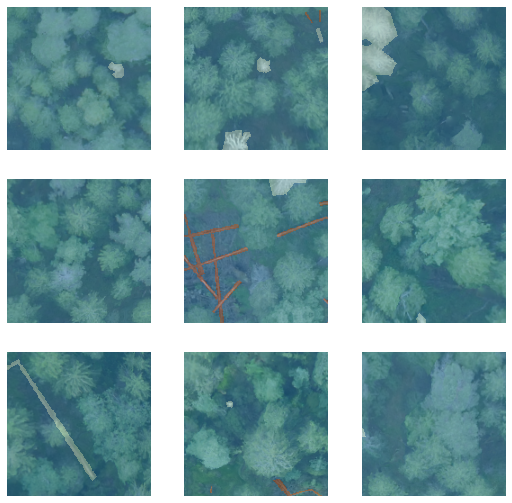

In [ ]:
deadwood.show_batch()

Create a unet_learner with pretrained resnet50 as a backbone.

In [ ]:
learn = unet_learner(deadwood, resnet101, pretrained=True, n_in=3, n_out=3, 
                     metrics=[foreground_acc, JaccardCoeff()]).to_fp16()

Due to memory issues, use mixed-precision training here.

Fine-tune for 1 freeze-epoch and 10 training epochs.

In [ ]:
learn.fine_tune(30,freeze_epochs=3)

epoch,train_loss,valid_loss,foreground_acc,jaccard_coeff,time
0,0.549134,0.137269,0.220519,0.706532,00:33
1,0.266042,0.106721,0.373099,1.337478,00:23
2,0.175850,0.199464,0.173665,0.116196,00:23


epoch,train_loss,valid_loss,foreground_acc,jaccard_coeff,time
0,0.097762,0.077483,0.609530,2.134722,00:26
1,0.083668,0.069397,0.676454,2.456564,00:25
2,0.078623,0.070744,0.708922,2.424835,00:25
3,0.074409,0.069033,0.607327,2.389635,00:25
4,0.073938,0.064570,0.717143,2.720913,00:25
5,0.073020,0.074971,0.728276,2.520584,00:25
6,0.070050,0.069507,0.676189,2.738098,00:25
7,0.068727,0.059939,0.738709,2.721020,00:25
8,0.065777,0.071425,0.832580,2.483030,00:25
9,0.063757,0.057921,0.752568,2.772205,00:25


Return to full-precision.

In [ ]:
learn.to_fp32()

See results.

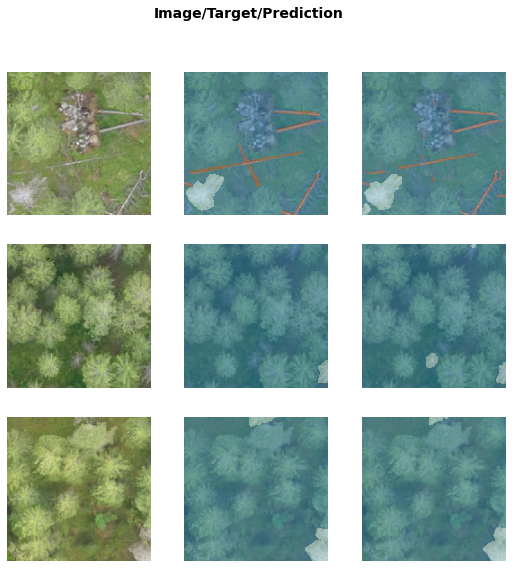

In [ ]:
learn.show_results(max_n=9)

In [ ]:
preds = learn.get_preds(with_input=True, with_decoded=True)

More informative way to see predictions.

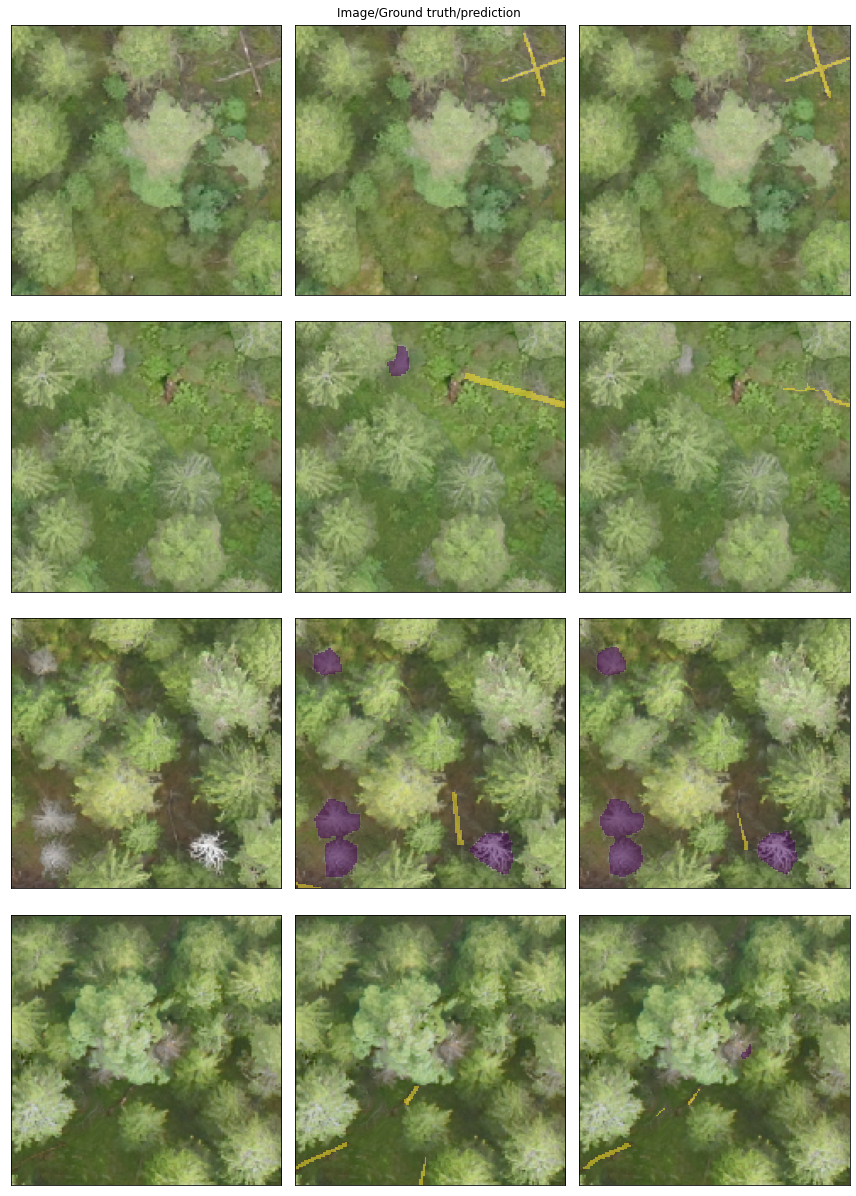

In [ ]:
show_im_mask_pred(preds, max_n=4)